#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Вам нужно:

Загрузить данные и выполнить их ресемплирование по одному часу.
Проанализировать данные.
Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
Проверить данные на тестовой выборке и сделать выводы.
Данные лежат в файле taxi.csv. Количество заказов находится в столбце num_orders (от англ. number of orders, «число заказов»).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

from statsmodels.tsa.seasonal import seasonal_decompose

## Подготовка

In [ ]:
from google.colab import files

# Загружаем сразу несколько файлов (можно выделить их при выборе)
uploaded = files.upload()

Saving taxi.csv to taxi.csv


In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
data = pd.read_csv('taxi.csv', sep=',', index_col=[0], parse_dates=[0])
display(data.head(6))
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.head(5)

<ipython-input-5-d16ecd3d219c>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('1H').sum()


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Загрузили данные, поставили формат datetime. Сделали ресемплирование по 30минут.

## Анализ

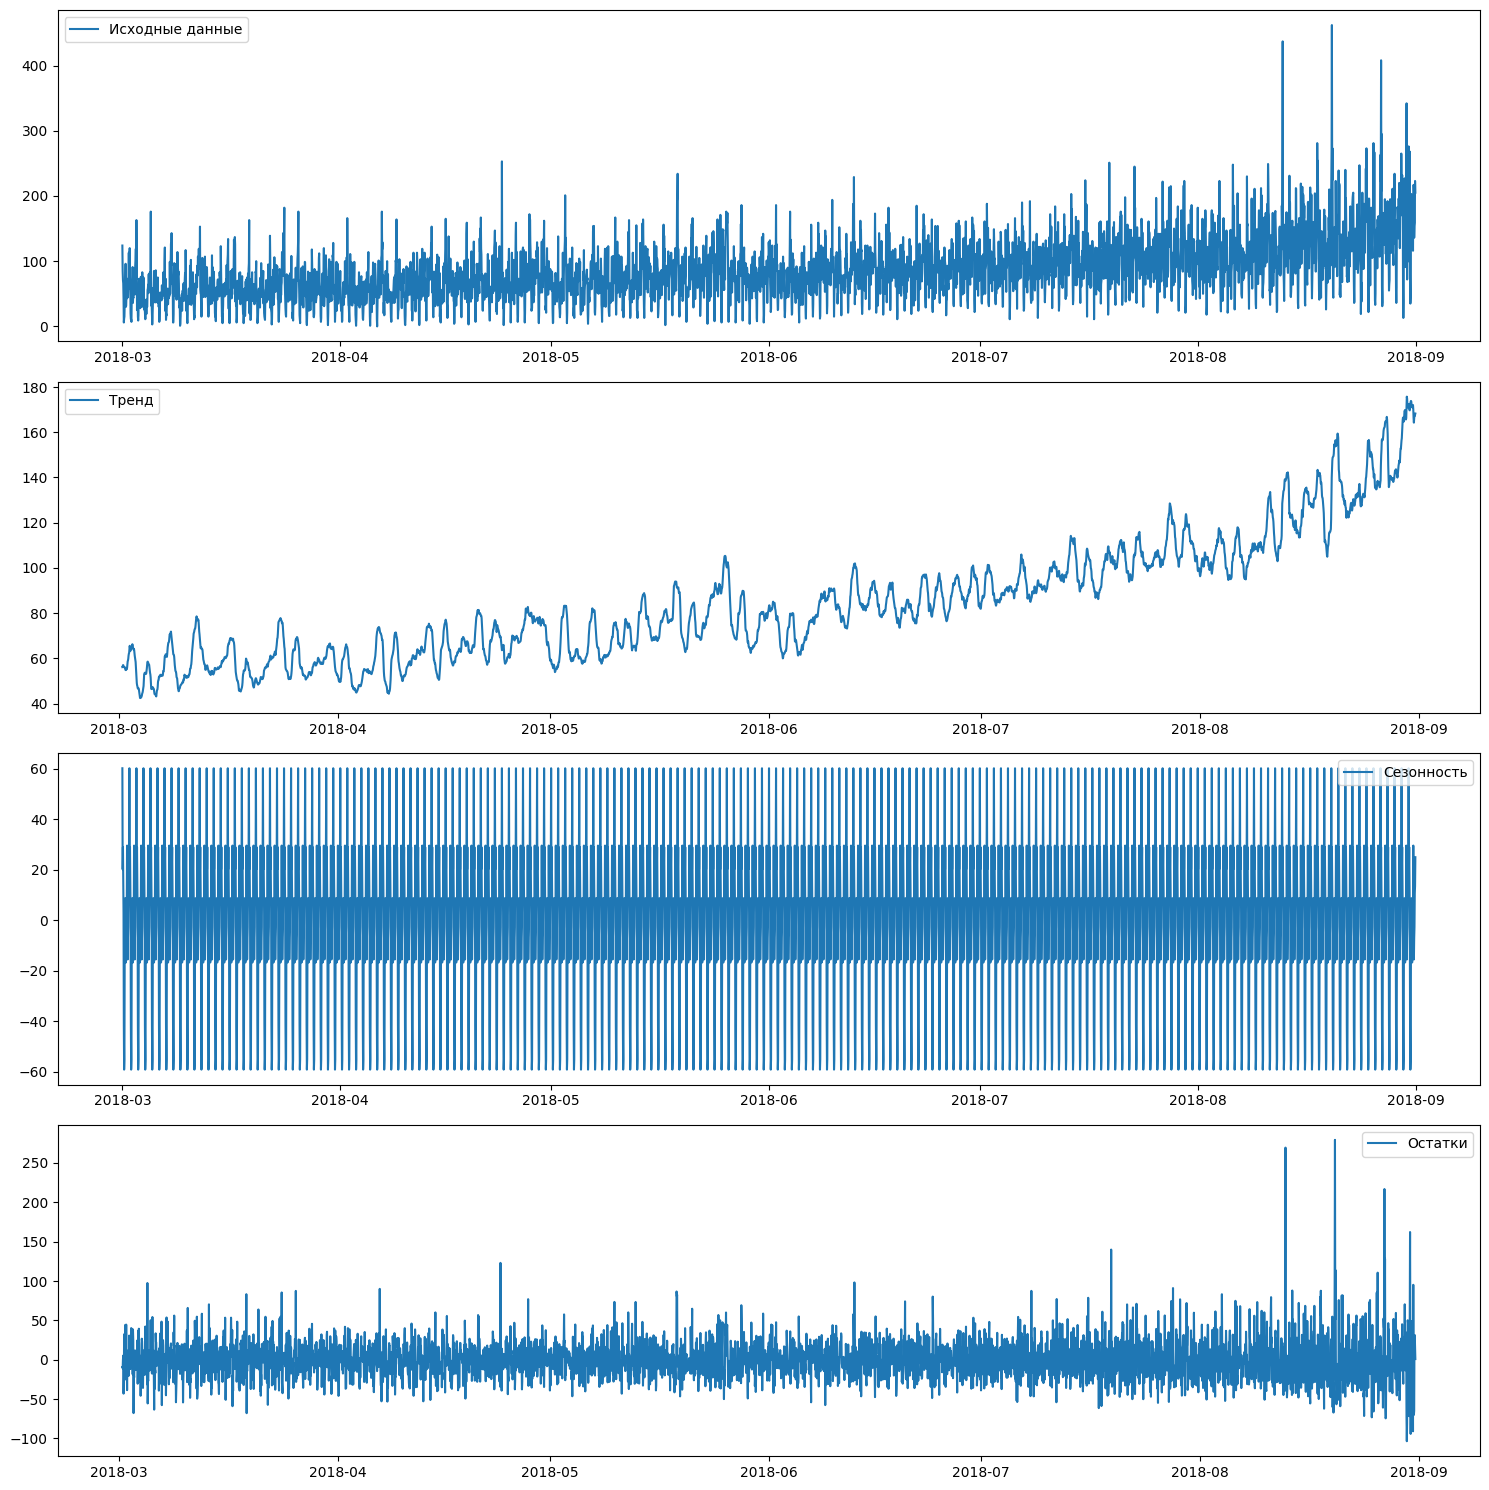

In [ ]:
decomposition = seasonal_decompose(data)

plt.figure(figsize=(15, 15))

plt.subplot(411)
plt.plot(decomposition.observed, label='Исходные данные')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Тренд')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Сезонность')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Остатки')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

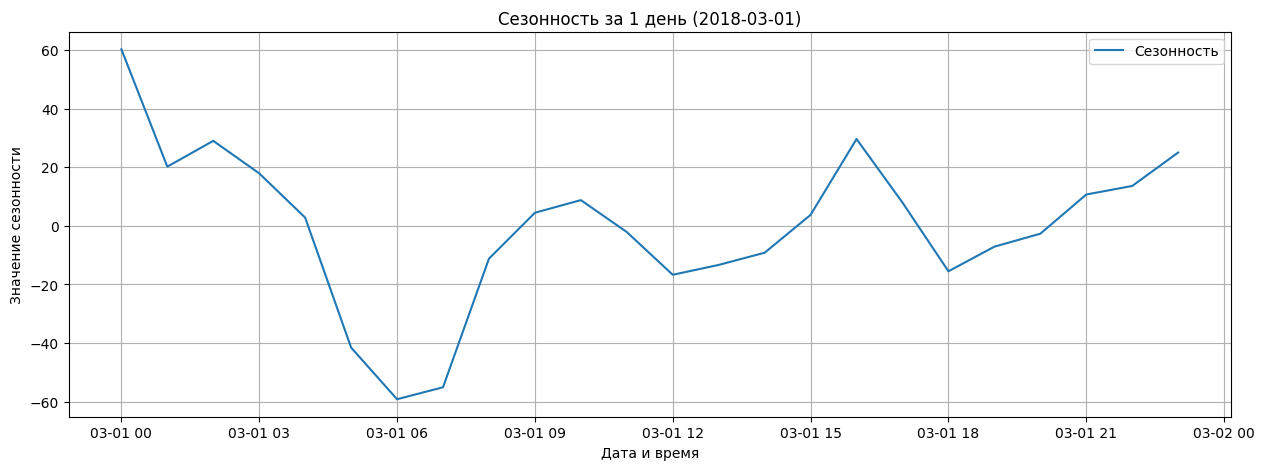

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(111)

plt.plot(decomposition.seasonal['2018-03-01'], label='Сезонность')
plt.legend(loc='best')
plt.xlabel("Дата и время")
plt.ylabel("Значение сезонности")
plt.title("Сезонность за 1 день (2018-03-01)")
plt.grid(True)

plt.show()

Тренд положительный на всем отрезке, 09.2018 самый большой пик. В сезонности за сутки видим, что меньше всего заказов в 6 утра, больше всего в 00.

## Обучение

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
#    data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

    return data

data = make_features(data, 24, 24)

# Удаление пропусков, возникших после создания признаков
data = data.dropna()

In [ ]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [ ]:
# Определение числовых и категориальных признаков (после создания признаков):
numerical_features = ['rolling_mean'] + [f'lag_{i}' for i in range(1, 25)]
categorical_features = ['dayofweek', 'hour']

# Создание ColumnTransformer:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

In [ ]:
pipeline_lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMRegressor(objective='rmse', metric='rmse', random_state=42, verbose=-1))
])

param_grid_lgbm = {
    'model__n_estimators': [50, 100],
    'model__learning_rate': [0.01, 0.1],
    'model__num_leaves': [20, 31]
}

pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

param_grid_rf = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [5, 10]
}

In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
grid_search_lgbm = GridSearchCV(pipeline_lgbm,
                               param_grid_lgbm,
                               scoring='neg_root_mean_squared_error',
                               cv=tscv,
                               n_jobs=-1,
                               verbose=1)

grid_search_rf = GridSearchCV(pipeline_rf,
                             param_grid_rf,
                             scoring='neg_root_mean_squared_error',
                             cv=tscv,
                             n_jobs=-1,
                             verbose=1)

In [ ]:
# Обучение GridSearchCV для каждой модели:
grid_search_lgbm.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['rolling_mean',
                                                                          'lag_1',
                                                                          'lag_2',
                                                                          'lag_3',
                                                                          'lag_4',
                                                                          'lag_5',
                                                                          'lag_6',
                                                                          'lag_7',
                                                                          'lag_8',
                                                                          'lag_9',
                                                                          'lag_10',
                                                                          'lag_11',
                                                                          'lag_12',
                                                                          'lag_13',
                                                                          'lag_14',
                                                                          'lag_15',
                                                                          'lag_16',
                                                                          'lag_17',
                                                                          'lag_18',
                                                                          'lag_19',
                                                                          'lag_20',
                                                                          'lag_21',
                                                                          'lag_22',
                                                                          'lag_23',
                                                                          'lag_24']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['dayofweek',
                                                                          'hour'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [5, 10],
                         'model__n_estimators': [50, 100]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [ ]:
# Вывод лучших параметров и результатов для каждой модели:
print("LightGBM: Лучшие параметры:", grid_search_lgbm.best_params_)
print("LightGBM: Лучший RMSE:", -grid_search_lgbm.best_score_)

print("RandomForest: Лучшие параметры:", grid_search_rf.best_params_)
print("RandomForest: Лучший RMSE:", -grid_search_rf.best_score_)

LightGBM: Лучшие параметры: {'model__learning_rate': 0.1, 'model__n_estimators': 100, 'model__num_leaves': 20}
LightGBM: Лучший RMSE: 26.253312051584686
RandomForest: Лучшие параметры: {'model__max_depth': 10, 'model__n_estimators': 100}
RandomForest: Лучший RMSE: 27.05932414765857


## Тестирование

In [ ]:
# Лучшая модель
best_model = grid_search_lgbm.best_estimator_

# Прогноз на тестовых данных с использованием лучшей модели
y_pred = best_model.predict(X_test)

# Оценка производительности на тестовых данных
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE на тестовых данных: {rmse}")

RMSE на тестовых данных: 41.01040154295471


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Оценка на тестовой выборке для каждой модели:
best_model_lgbm = grid_search_lgbm.best_estimator_
predictions_lgbm = best_model_lgbm.predict(X_test)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, predictions_lgbm))

best_model_rf = grid_search_rf.best_estimator_
predictions_rf = best_model_rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, predictions_rf))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


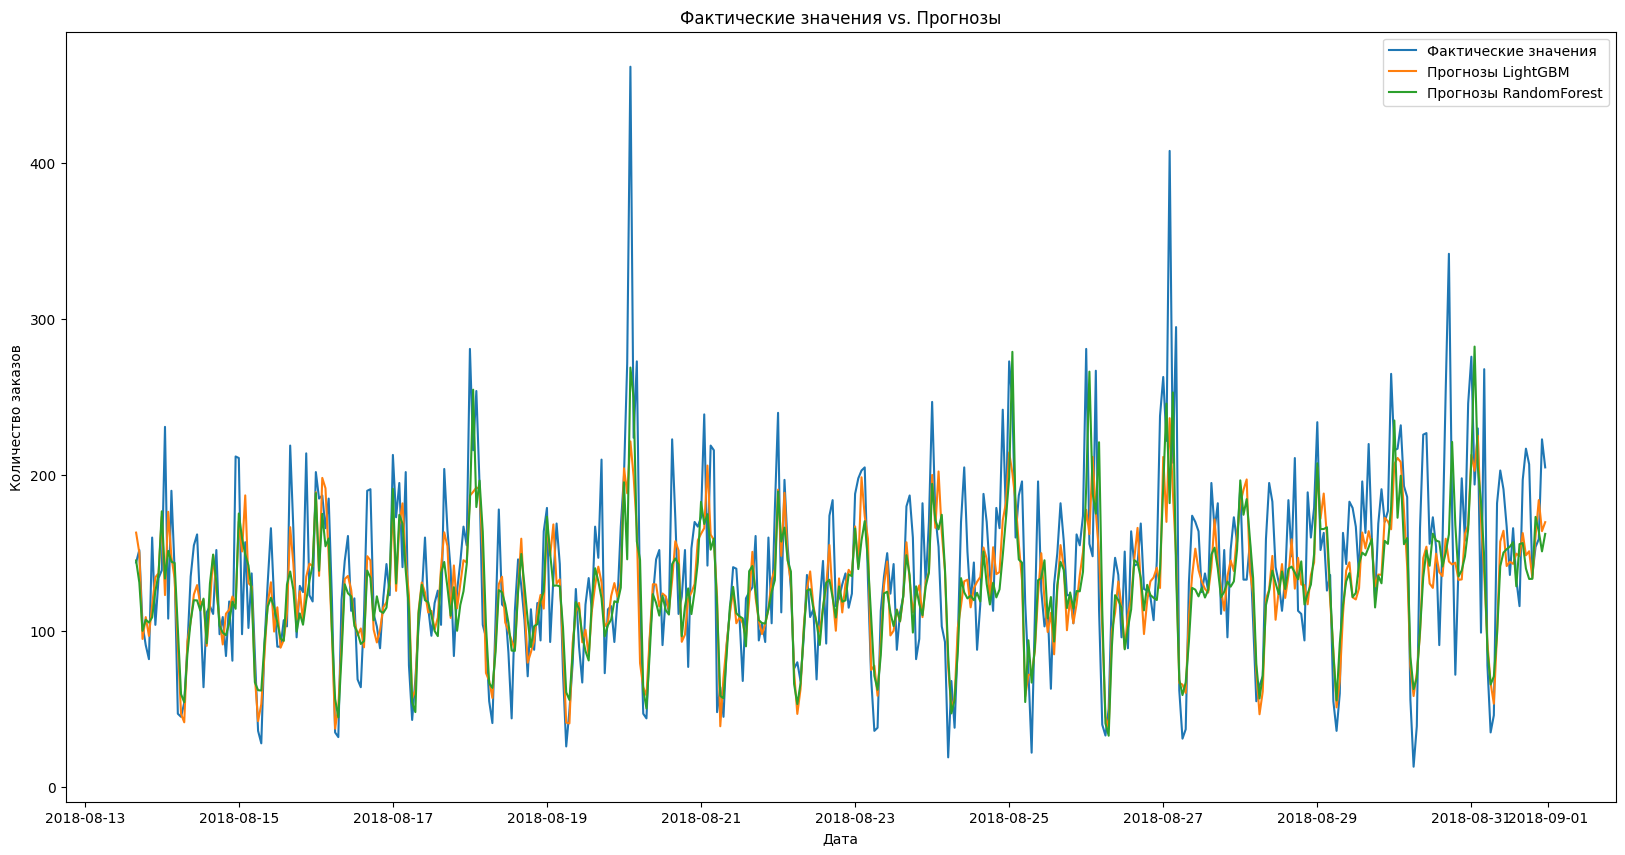

In [ ]:
# Визуализация прогнозов для каждой модели:
plt.figure(figsize=(20, 10))
plt.plot(y_test.index, y_test, label='Фактические значения')
plt.plot(y_test.index, predictions_lgbm, label='Прогнозы LightGBM')
plt.plot(y_test.index, predictions_rf, label='Прогнозы RandomForest')
plt.title('Фактические значения vs. Прогнозы')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

Были загружены данные, добавлены новые признаки, сделан пайплайн перебирающий параметры у RF и LGBM моделей.
Обе модели показали хороший результат удовлетворяющий условиям, значение метрики RMSE на тестовой выборке должно быть не больше 48. Лучше всего себя показала LightGBM: {'model__learning_rate': 0.1, 'model__n_estimators': 100, 'model__num_leaves': 20} ее RMSE равна на тестовой 41. Представлены графики для наглядного понимания разницы предсказания моделей.